# Explore here

In [107]:
!pip install -r "/workspaces/machine-learning-python-template/requirements.txt"


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [109]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv'
raw_data = pd.read_csv(url)

raw_data.to_csv('/workspaces/machine-learning-python-template/data/raw/.gitkeep', index=False)


In [110]:
df = pd.read_csv('/workspaces/machine-learning-python-template/data/raw/.gitkeep')



In [111]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [112]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [113]:
df.loc[df.duplicated()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


In [114]:
df.loc[df.duplicated(subset=["id"])]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


In [115]:
df.loc[df.duplicated(subset=["host_id"])]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
22,8025,CBG Helps Haiti Room#2.5,22486,Lisel,Brooklyn,Park Slope,40.67989,-73.97798,Private room,80,1,39,2019-01-01,0.37,6,364
23,8110,CBG Helps Haiti Rm #2,22486,Lisel,Brooklyn,Park Slope,40.68001,-73.97865,Private room,110,2,71,2019-07-02,0.61,6,304
33,9783,back room/bunk beds,32294,Ssameer Or Trip,Manhattan,Harlem,40.82130,-73.95318,Private room,50,3,273,2019-07-01,2.37,3,359
35,10962,"Lovely room 2 & garden; Best area, Legal rental",9744,Laurie,Brooklyn,South Slope,40.66869,-73.98780,Private room,89,4,168,2019-06-21,1.41,3,340
39,12048,LowerEastSide apt share shortterm 1,7549,Ben,Manhattan,Lower East Side,40.71401,-73.98917,Shared room,40,1,214,2019-07-05,1.81,4,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48887,36483152,Garden Jewel Apartment in Williamsburg New York,208514239,Melki,Brooklyn,Williamsburg,40.71232,-73.94220,Entire home/apt,170,1,0,NaN,NaN,3,365
48889,36484363,QUIT PRIVATE HOUSE,107716952,Michael,Queens,Jamaica,40.69137,-73.80844,Private room,65,1,0,NaN,NaN,2,163
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36


In [116]:
df.query('host_id == 7549')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188
39,12048,LowerEastSide apt share shortterm 1,7549,Ben,Manhattan,Lower East Side,40.71401,-73.98917,Shared room,40,1,214,2019-07-05,1.81,4,188
4767,3373030,"Cute,Cozy Lower East Side 1bdrm",7549,Ben,Manhattan,Lower East Side,40.71307,-73.99025,Entire home/apt,150,1,60,2019-06-25,1.00,4,188
5778,4215595,LowerEastSide apt share shortterm 3,7549,Ben,Manhattan,Lower East Side,40.71329,-73.99047,Shared room,40,1,88,2019-05-19,1.53,4,197


In [117]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [118]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [119]:
df = df[['host_id', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365']]

In [120]:
df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


In [121]:
df.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327
std,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000
25%,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000
50%,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000
75%,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000


In [122]:
df["neighbourhood"].value_counts().head(20)

neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
East Harlem           1117
Greenpoint            1115
Chelsea               1113
Lower East Side        911
Astoria                900
Washington Heights     899
West Village           768
Financial District     744
Flatbush               621
Clinton Hill           572
Name: count, dtype: int64

In [123]:
df.isnull().sum()


host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

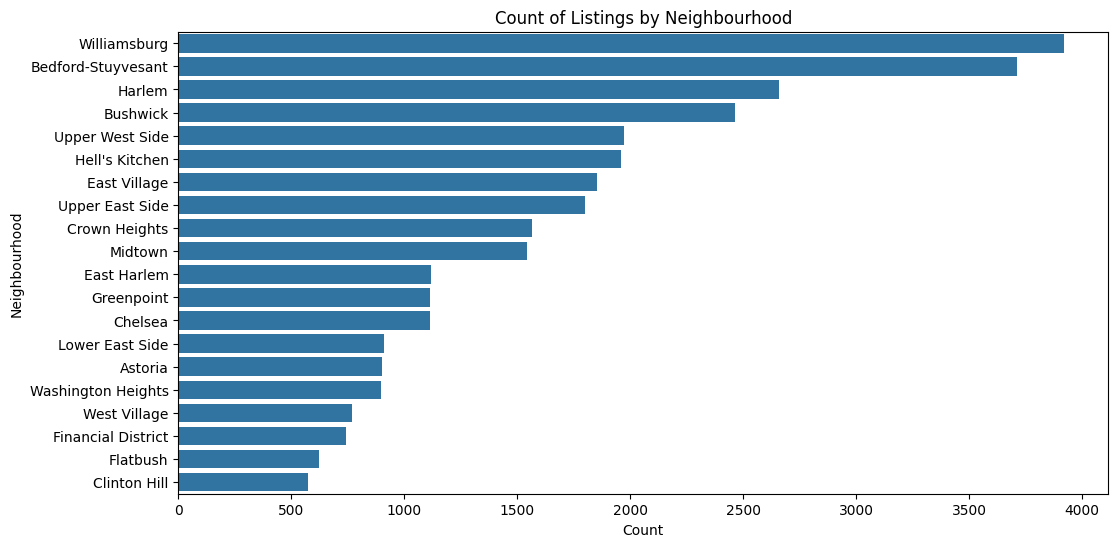

In [124]:
plt.figure(figsize=(12, 6))
sns.countplot(y='neighbourhood', data=df, order=df['neighbourhood'].value_counts().nlargest(20).index)
plt.title('Count of Listings by Neighbourhood')
plt.xlabel('Count')
plt.ylabel('Neighbourhood')
plt.show()


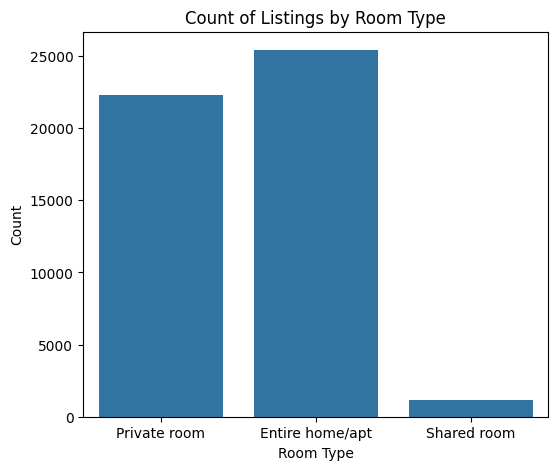

In [125]:
plt.figure(figsize=(6, 5))
sns.countplot(x='room_type', data=df)
plt.title('Count of Listings by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()


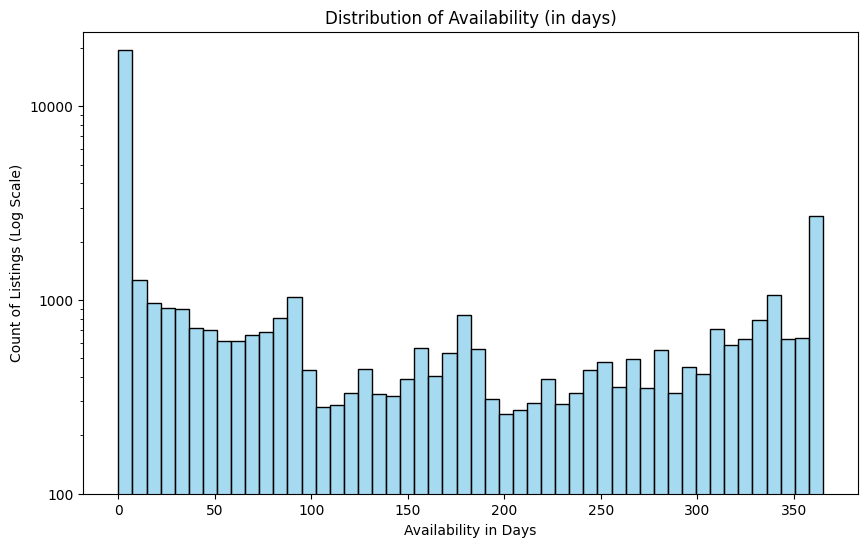

In [126]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))
sns.histplot(df['availability_365'], bins=50, kde=False, color='skyblue')

plt.yscale('log') 

ticks = [100, 1000, 10000]  # Example of custom ticks
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_ticks(ticks)

plt.title('Distribution of Availability (in days)')
plt.xlabel('Availability in Days')
plt.ylabel('Count of Listings (Log Scale)')
plt.show()

In [127]:
df.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

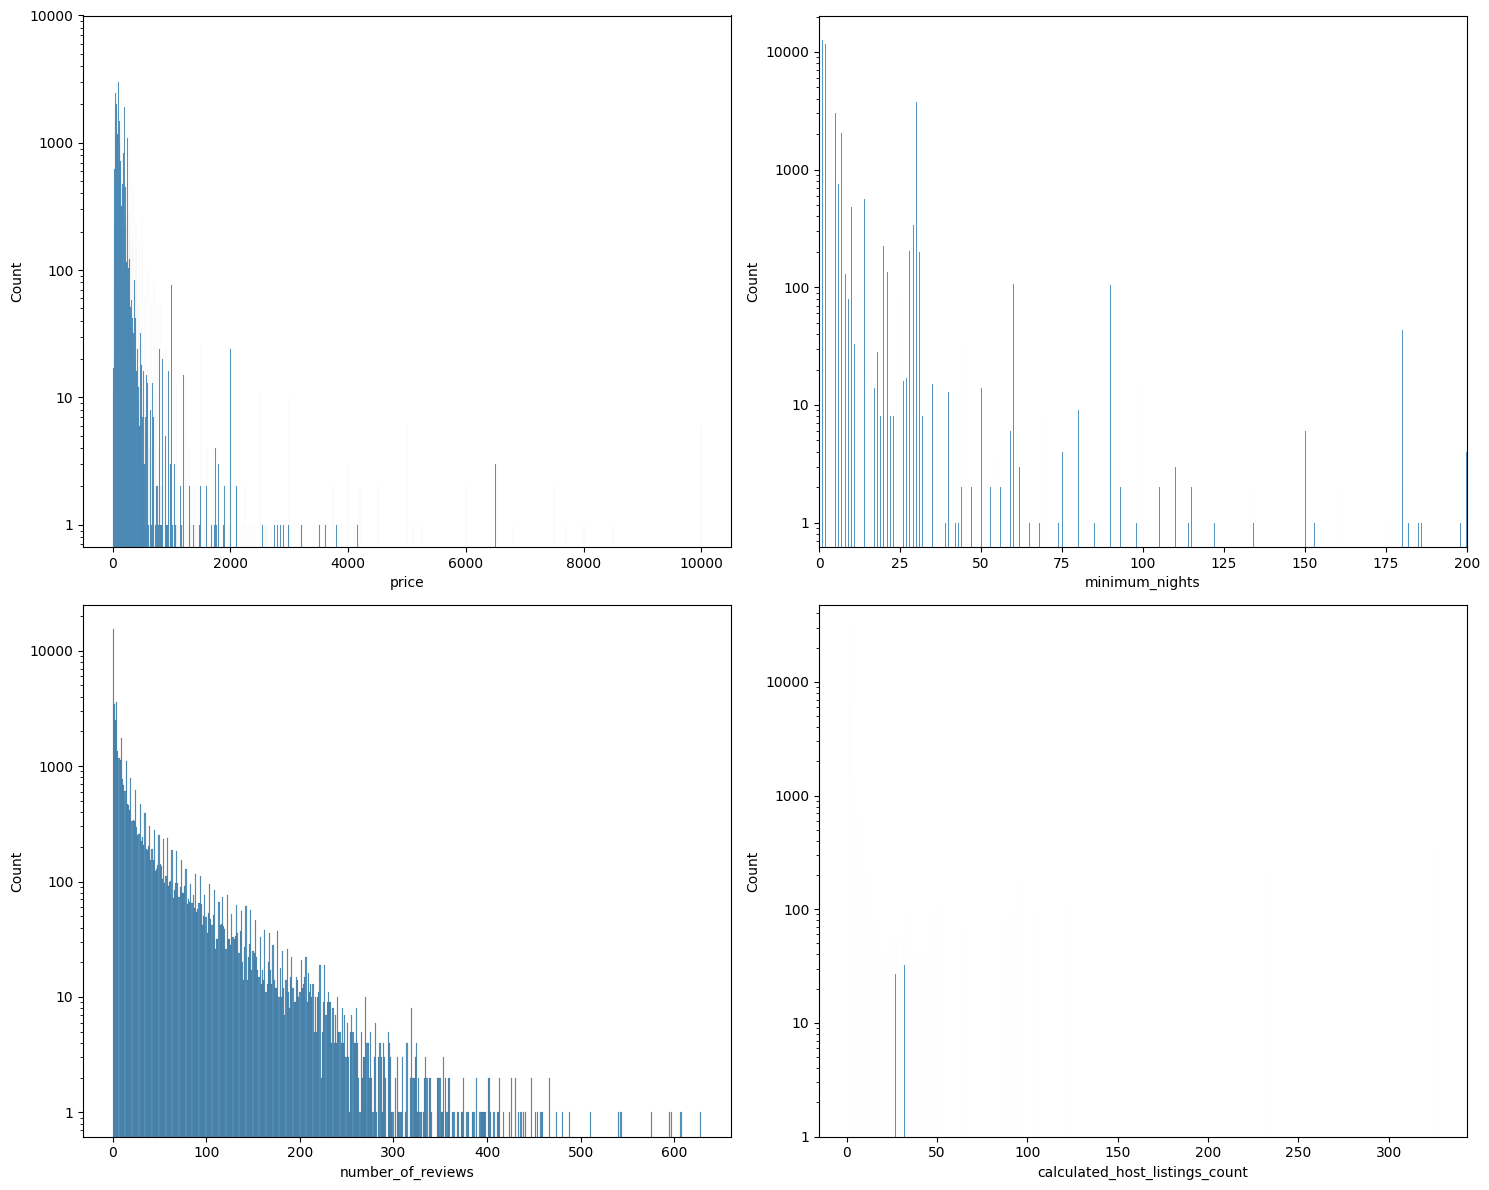

In [128]:
fig, axis = plt.subplots(2, 2, figsize=(15, 12))

sns.histplot(ax=axis[0, 0], data=df, x="price")
axis[0, 0].set_yscale('log')
axis[0, 0].yaxis.set_major_formatter(ticker.ScalarFormatter())
axis[0, 0].yaxis.set_ticks([1, 10, 100, 1000, 10000])

sns.histplot(ax=axis[0, 1], data=df, x="minimum_nights").set_xlim(0, 200)
axis[0, 1].set_yscale('log')
axis[0, 1].yaxis.set_major_formatter(ticker.ScalarFormatter())
axis[0, 1].yaxis.set_ticks([1, 10, 100, 1000, 10000])

sns.histplot(ax=axis[1, 0], data=df, x="number_of_reviews")
axis[1, 0].set_yscale('log')
axis[1, 0].yaxis.set_major_formatter(ticker.ScalarFormatter())
axis[1, 0].yaxis.set_ticks([1, 10, 100, 1000, 10000])

sns.histplot(ax=axis[1, 1], data=df, x="calculated_host_listings_count")
axis[1, 1].set_yscale('log')
axis[1, 1].yaxis.set_major_formatter(ticker.ScalarFormatter())
axis[1, 1].yaxis.set_ticks([1, 10, 100, 1000, 10000])

plt.tight_layout()
plt.show()

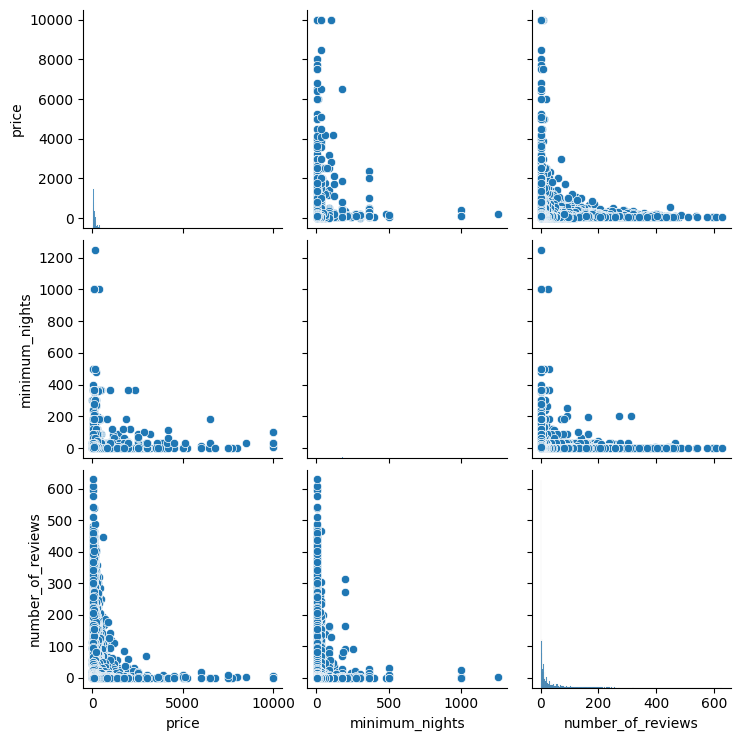

In [129]:
sns.pairplot(df, vars=['price','minimum_nights', 'number_of_reviews'])
plt.show()

Correlation Matrix:
                    price  minimum_nights
price           1.000000        0.042799
minimum_nights  0.042799        1.000000


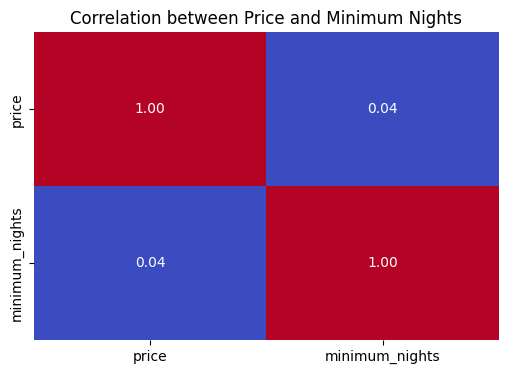

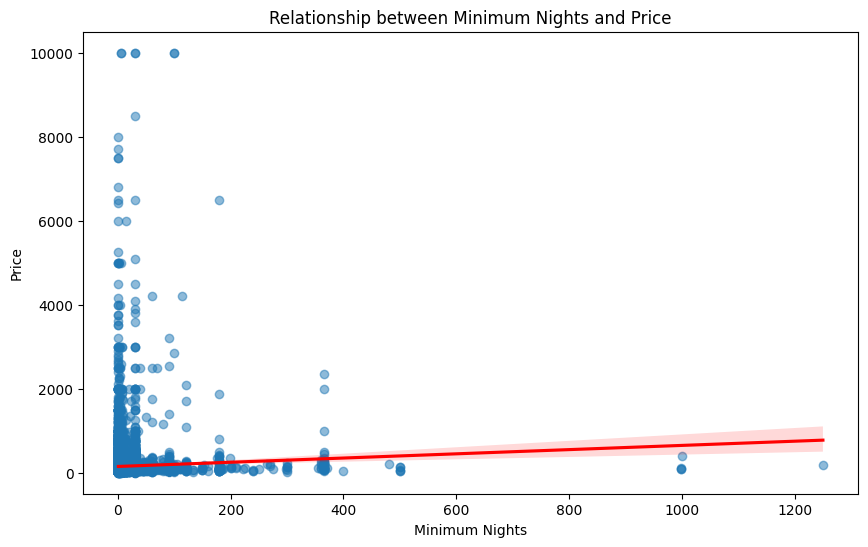

In [130]:
correlation = df[['price', 'minimum_nights']].corr()
print("Correlation Matrix:\n", correlation)

plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
plt.title('Correlation between Price and Minimum Nights')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x='minimum_nights', y='price', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between Minimum Nights and Price')
plt.xlabel('Minimum Nights')
plt.ylabel('Price')
plt.show()

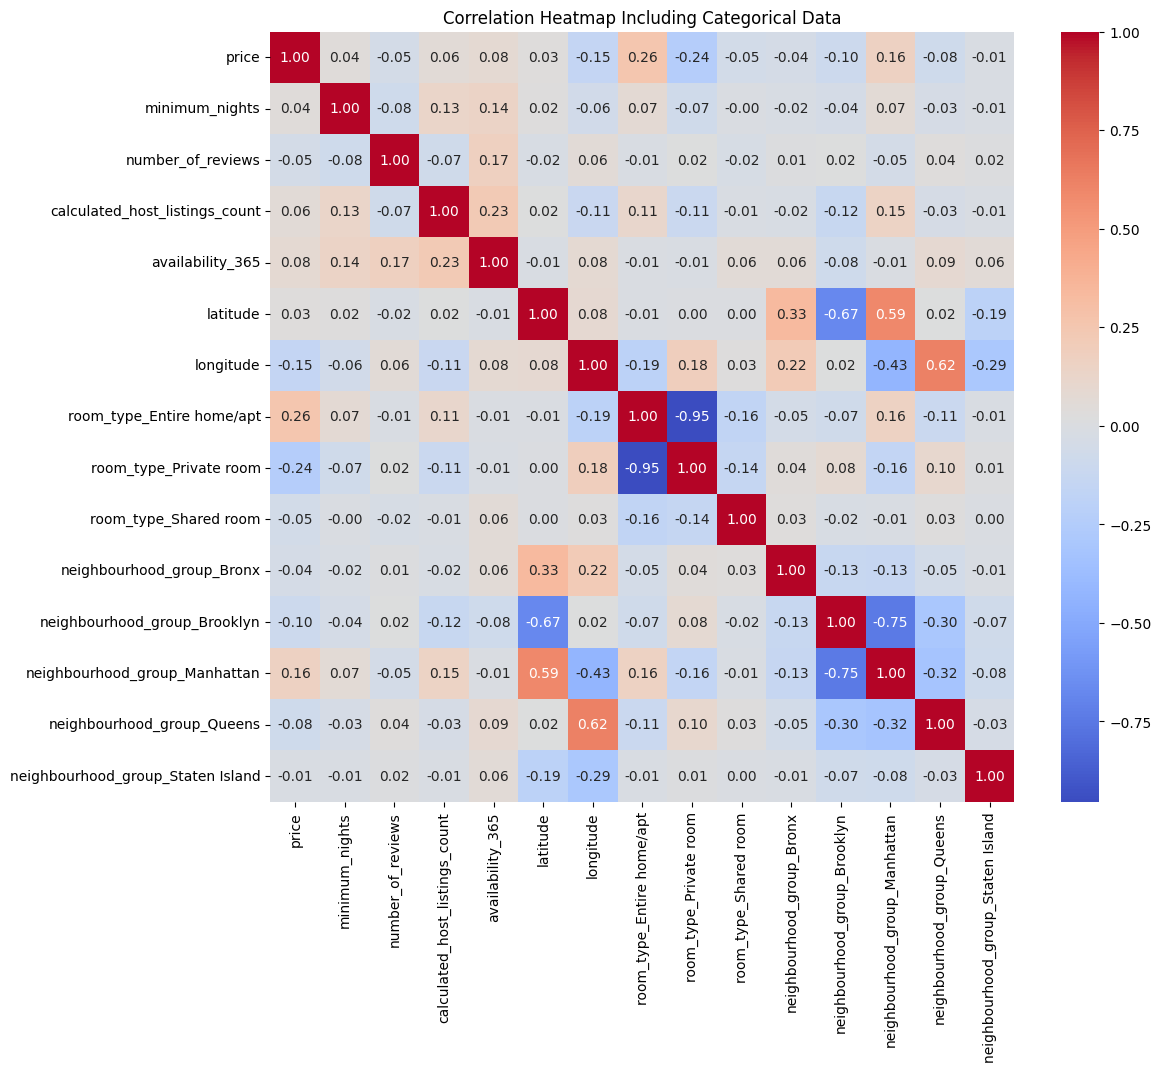

In [131]:
numerical_columns = ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude']

df_encoded = pd.get_dummies(df[['room_type', 'neighbourhood_group']], drop_first=False)

df_combined = pd.concat([df[numerical_columns], df_encoded], axis=1)

correlation_matrix_combined = df_combined.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_combined, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap Including Categorical Data')
plt.show()

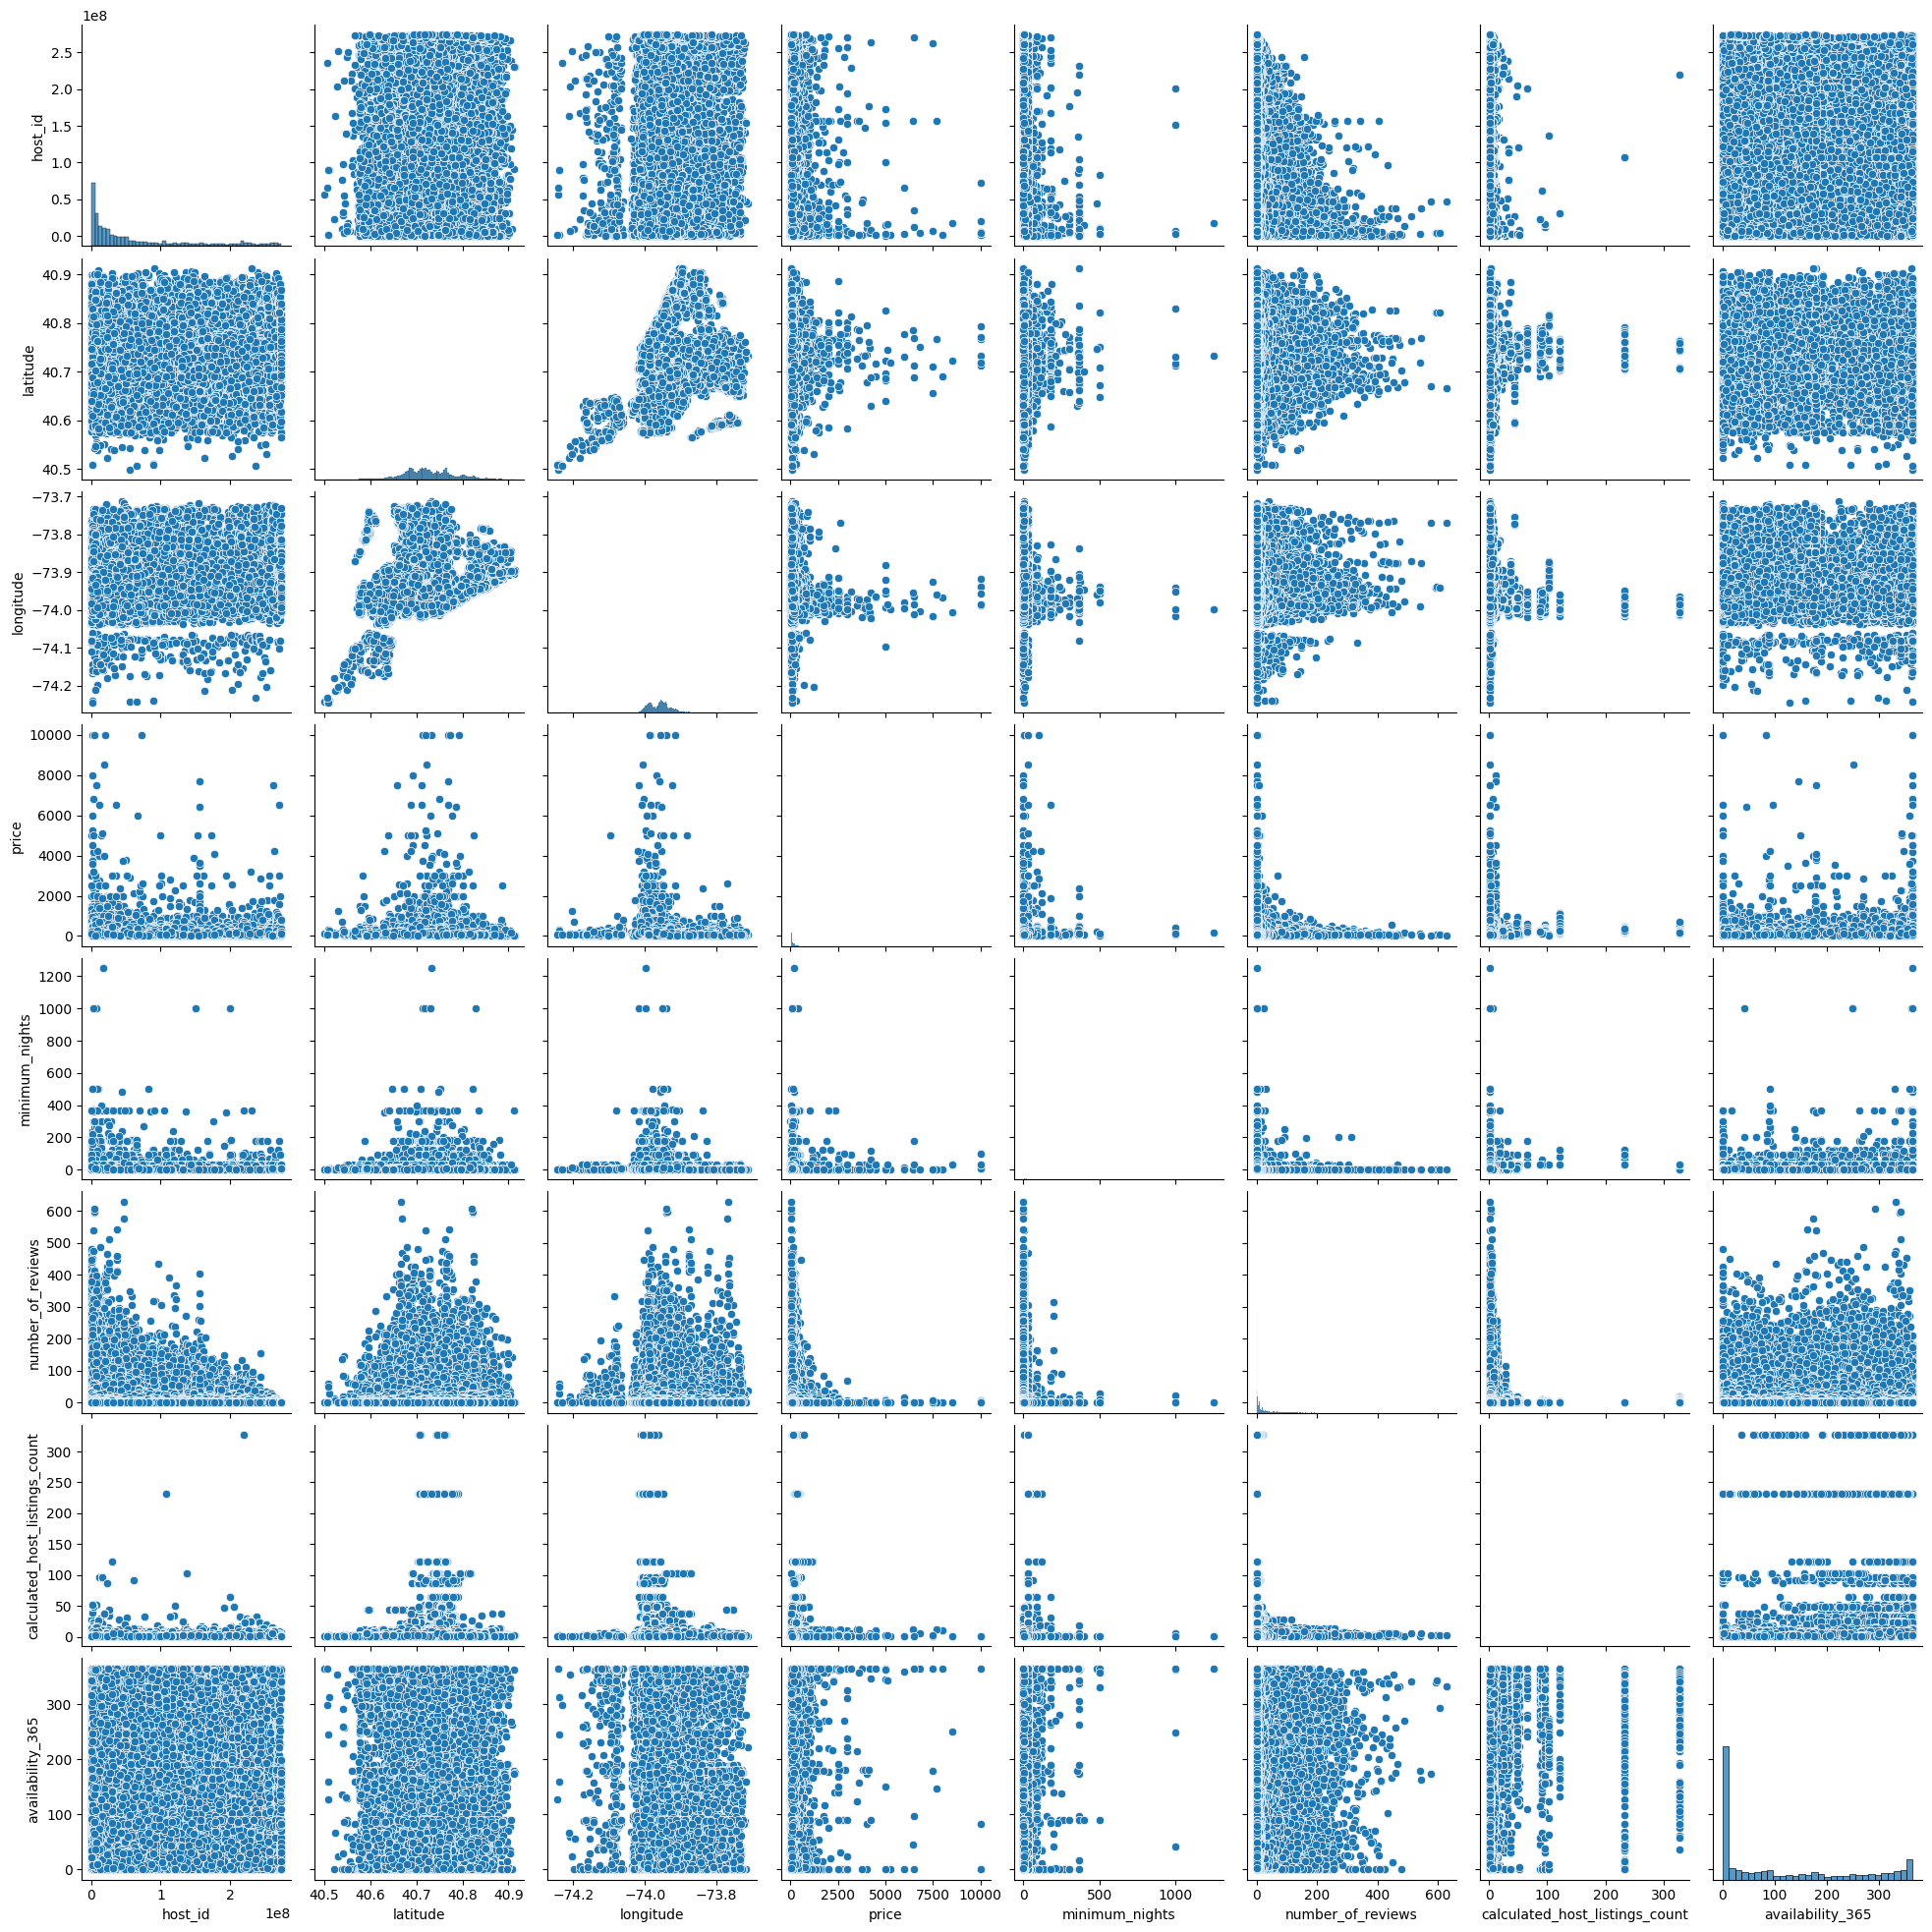

In [132]:
sns.pairplot(data = df)

In [133]:
df["price"].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [134]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

df_encoded = pd.get_dummies(df[['neighbourhood_group', 'room_type']])

num_variables = ["number_of_reviews", "minimum_nights", "calculated_host_listings_count", "availability_365"]
df_num = df[num_variables]

df_combined = pd.concat([df_num, df_encoded], axis=1)

scaler = MinMaxScaler()
scal_features = scaler.fit_transform(df_combined)
df_scal = pd.DataFrame(scal_features, index=df.index, columns=df_combined.columns)

df_scal["price"] = df["price"]

df_scal.head()


,number_of_reviews,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,price
0,0.014308,0.000000,0.015337,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,149
1,0.071542,0.000000,0.003067,0.972603,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,225
2,0.000000,0.001601,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,150
3,0.429253,0.000000,0.000000,0.531507,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,89
4,0.014308,0.007206,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,80


In [137]:
from sklearn.model_selection import train_test_split

X = df_scal.drop("price", axis = 1)
y = df_scal["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

selected_columns = ["minimum_nights", "calculated_host_listings_count", "availability_365", "room_type_Entire home/apt"]
X_train_sel = X_train[selected_columns]
X_test_sel = X_test[selected_columns]

X_train_sel.head()


,minimum_nights,calculated_host_listings_count,availability_365,room_type_Entire home/apt
32645,0.001601,0.000000,0.002740,1.0
23615,0.000801,0.000000,0.000000,0.0
31183,0.000801,0.003067,0.000000,0.0
29260,0.001601,0.000000,0.731507,1.0
7275,0.003203,0.000000,0.000000,0.0


In [138]:
X_train_sel["price"] = list(y_train)
X_test_sel["price"] = list(y_test)
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

/tmp/ipykernel_3257/116964019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_sel["price"] = list(y_train)
/tmp/ipykernel_3257/116964019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_sel["price"] = list(y_test)
